# AirBnB Daily Price Predictions

![AirBnB](../Images/airbnb3.jpeg)

### Import Necessary Libraries

In [2]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn
import time
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from geopy.distance import geodesic

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Overview / Business Problem

The target stakeholder is an AirBnB owner who owns property either in the cities of Asheville, Nashville, or Austin. AirBnB has provided a unique opportunity for homeowners to create a stream of income through their property. Prior experience with owning or renting real estate is not a requirement to list a home on AirBnb. As such, it is up to the discretion of the AirBnB lister to determine the daily price to charge. Listing a home for too high of a price could result in low demand and listing a price for too low could result in lost out potential income. The predictive modeling below will utilize a city’s past AirBnB listing data for the year of 2022. By utilizing this historical data, the model will predict prices for the 2023 calendar year based on attribute of the AirBnB owner’s home.

## Data Understanding

**[The data](http://insideairbnb.com/get-the-data/)** set comes from Inside AirBnB, a data sharing site devoted to collecting data on dozens of cities and countries around the world. There are two data sets for each city – a detailed calendar data set and a listings data set. Within the calendar data, there is 365 rows for each AirBnB listing, represent each day of the year and the price and other information. The breakdown of each city and the respective datasets is below:

-	**Asheville:**
    - Calendar Data:
        - 958,490 rows
        - 7 columns
    - Listings Data:
        - 2,626 rows
        - 74 columns
-	**Nashville:**
    - Calendar Data:
        - 2,320,689 rows
        - 7 columns
    - Listings Data:
        - 6,359 rows
        - 74 columns
-	**Austin:**
    - Calendar Data:
        - 4,369,416 rows
        - 7 columns
    - Listings Data:
        - 11,971 rows
        - 74 columns

## Exploratory Data Analysis (EDA)

**Calendar Data:**
The first data set utilized, the 'calendar data' has seven columns, outlined below. The data set contains 365 rows for each AirBnB. The earliest date is 12/15/2021 and the latest is 12/17/2022. The main steps of EDA performed on the calendar data set were:

 - 1) Converting the date column to date-time
 - 2) Converting the columns with 'object' types of 't' and 'f' to binary (0, 1) values
 - 3) Removing NaN values
 - 4) Removing 'available', 'minimum nights', and 'maximum nights' columns as these will be irrelevant from the stakeholder's perspective
 
As shown below, after performing these steps the data set was left with three columns (listing_id, daily_price, date) and 958,489 rows.

In [3]:
raw_asheville_calendar_data = pd.read_pickle('../Supplements/Pickles/raw_asheville_calendar_data.pickle')
raw_asheville_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   listing_id      958490 non-null  int64 
 1   date            958490 non-null  object
 2   available       958490 non-null  object
 3   price           958319 non-null  object
 4   adjusted_price  958319 non-null  object
 5   minimum_nights  958490 non-null  int64 
 6   maximum_nights  958490 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 51.2+ MB


In [4]:
print(f"Earliest date of data set {raw_asheville_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_asheville_calendar_data['date'].max()}")

Earliest date of data set 2021-12-15
Latest date of data set 2022-12-17


In [5]:
pd.read_pickle('../Supplements/Pickles/mod_asheville_calendar_data.pickle').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 29.2 MB


**Listings Data:** The second data set utilized, the 'listings data' has 74 columns, outlined below. The data set contains one row for each AirBnB totaling 2,626 rows. The earliest date is 12/15/2022 and the latest is 12/17/2023. The main steps of EDA performed on the calendar data set were:

 - 1) Removing columns which will be irrelevant to the stakeholder, including:
    - a) All columns related to rating
    - b) Most columns related to the host including name, picture, response time, etc. with the exception of whether or not the host is a superhost
    - c) Columns related to scraping, the minimum/maximum nights, availability and price as the daily price from the calendar data set will be utilized
 - 2) Filling in any missing neighborhood data with the most common neighborhood which was typically just the city name (Asheville, Nashville, and Austin)
 - 3) Dropping neighborhoods which do not fall into the top 5 by count
 - 4) Removing any NaNs values from columns such as bedrooms, beds, and bathrooms

As shown below, after performing these steps the data set was left with 28 columns and 2,269 rows.

In [6]:
pd.read_pickle('../Supplements/Pickles/raw_asheville_listings_data.pickle').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2626 non-null   int64  
 1   listing_url                                   2626 non-null   object 
 2   scrape_id                                     2626 non-null   int64  
 3   last_scraped                                  2626 non-null   object 
 4   name                                          2626 non-null   object 
 5   description                                   2621 non-null   object 
 6   neighborhood_overview                         2040 non-null   object 
 7   picture_url                                   2626 non-null   object 
 8   host_id                                       2626 non-null   int64  
 9   host_url                                      2626 non-null   o

In [7]:
pd.read_pickle('../Supplements/Pickles/mod_asheville_listing_data.pickle').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

**Combined Data:**
After performing the above EDA steps on each of the data sets, the data sets were combined based on the AirBnB listing id. Once the data was combined, outliers were dropped with the following criteria:
 - 1) Only including bathrooms which are between 1 and 5
 - 2) Only including bedrooms which are less than or equal to 6 and beds which are less than or equal to 11
 - 3) Excluding hotel rooms and shared rooms therefor only including entire home/apt and private room AirBnBs
 - 4) Limiting daily prices which are less than or equal to $1,000

**Adding Distance Analysis:**
In addition to the information provided by the data sets, location is another very important metric when determining an AirBnBs price. As such, below is an example of code utilized to determine the distance between a given AirBnB and popular tourist attractions (in the below Asheville case it is the Biltmore and downtown Asheville). By including this code, we are able to add two additional columns which show the distance in miles from an AirBnB to a tourist attraction and ultimately determine if this has a strong impact on predicting price.

```python
#Zip the latitude and longitude columns to a new column called 'coords'
asheville_data['coords'] = list(zip(asheville_data['latitude'],asheville_data['longitude']))

#Create variables for popular tourist attractions
biltmore = (35.54108101423884, -82.55210010496437) 
downtown = (35.60405939066325, -82.54533225431588)

#Calculate the distance in miles from the airbnb coords to the tourist attractions
for idx, coords in enumerate(asheville_data['coords']):
        asheville_data.loc[idx,'distance_to_biltmore'] = geodesic(coords, biltmore).miles
        asheville_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
    
```

**Example AirBnB:**
The below figure is a plot of a single Asheville AirBnB and 365 point of daily price data. As shown below, it is clear that there is a seasonal pattern related to price in Asheville with January through April trending between 90-110 dollars per night and between May and December trending between 115 - 120 dollars per night.

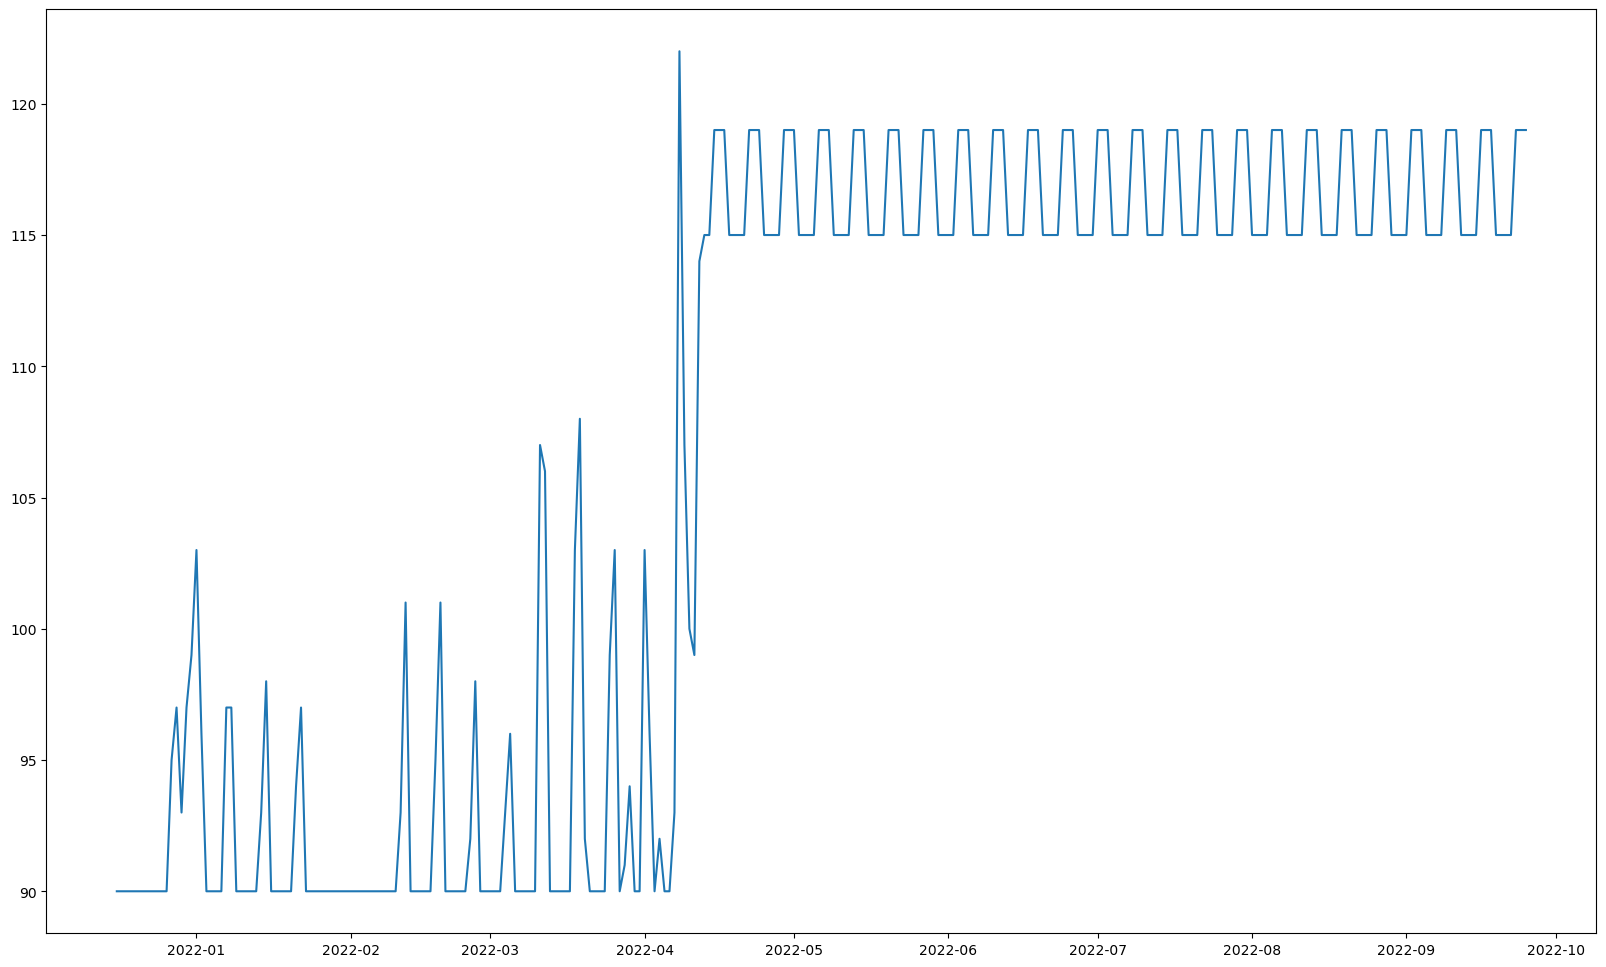

In [8]:
asheville_data = pd.read_pickle('../Supplements/Pickles/asheville_data.pickle')
graphing_one_bnb = asheville_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.show()

## Modeling

The data set utilized for the below models is the combined, cleaned Calendar and Listings data sets. To efficiently predict the AirBnB’s price, we will utilize Neural Network models, Random Forest Regressor modes, and an XGBoost model.

### Baseline Model

For the baseline model, we will utilize a simple Sequential neural-network model with two Dense layers, a flatten, and a dropout layer. 

```python

#One hot encode the categorical columns
baseline_model_sklearn = asheville_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse = False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                                      columns = ohe.get_feature_names_out())

#Create a data frame of numeric columns
baseline_model_numeric = asheville_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 
                                                  'bedrooms', 'beds', 'bathrooms', 'Air conditioning', 'Wifi', 'TV', 
                                                  'Kitchen', 'Washer', 'Dryer', 'Heating', 'week']]

#Merge the one hot encoded dataframe and the numeric columns
baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')

#Create a baseline X and y variable
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

#Split the data set to train and test
baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)
#Further split the data to a validation set
baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#Instantiate a new scaler and scale/transform the data
scaler = StandardScaler()
baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

#Instantiate a Regularizer
reg = l2(3e-3)

#Create a sequential model, add a flatten, a dense layer, followed by a dropout and another dense layer
baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

```

![Baseline](../Images/Asheville_Baseline_Model_Training_and_Validation_Loss.jpeg)

As shown below, while the model is not overfitting, it is clearly underperforming. A test MAE of $71 is too high relative to the average daily price. 

In [9]:
baseline_asheville_model_train_MAE = pd.read_pickle('../Supplements/Pickles/baseline_asheville_model_train_MAE.pickle')
print(f'Baseline Asheville Model Train MAE w/ Preds ${baseline_asheville_model_train_MAE}')

baseline_asheville_model_test_MAE = pd.read_pickle('../Supplements/Pickles/baseline_asheville_model_test_MAE.pickle')
print(f'Baseline Asheville Model Test MAE w/ Preds ${baseline_asheville_model_test_MAE}')
print(f'\n')
baseline_asheville_model_train_explained_var = pd.read_pickle('../Supplements/Pickles/baseline_asheville_model_train_explained_var.pickle')
print(f'Baseline Asheville Model Train Explained Variance {baseline_asheville_model_train_explained_var}')

baseline_asheville_model_test_explained_var = pd.read_pickle('../Supplements/Pickles/baseline_asheville_model_test_explained_var.pickle')
print(f'Baseline Asheville Model Test Explained Variance {baseline_asheville_model_test_explained_var}')

Baseline Asheville Model Train MAE w/ Preds $71.37140674246625
Baseline Asheville Model Test MAE w/ Preds $71.6572064640082


Baseline Asheville Model Train Explained Variance 0.4218564817006428
Baseline Asheville Model Test Explained Variance 0.4189322294050132


### Model 2

Given the underperformance of the baseline model, the second model will be a neural network model but will have more complexity. Rather than just two Dense layers, a flatten, and a dropout layer, the second model will have two Convolutional 1D layers, two Maxpooling 1D layers, and two Batch Normalization layers.

```python
#One hot encode the categorical columns
model2_sklearn = asheville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = asheville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_biltmore', 'distance_to_downtown']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model, add several convolutional 1D layers, flatten and dense layers
model2_nn = models.Sequential()
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

```

![Model 2](../Images/Asheville_Model_2_Training_and_Validation_Loss.jpeg)

As shown below, the model is performing slightly better than the baseline model with a test MAE of $53. While there is improvement, the model is still underperforming with an MAE too high relative to the average daily price. Going forward, we will utilize other model types for the balance of the models.

In [10]:
model2_asheville_train_MAE = pd.read_pickle('../Supplements/Pickles/model2_asheville_train_MAE.pickle')
print(f'Model 2 Asheville Train MAE w/ Preds ${model2_asheville_train_MAE}')

model2_asheville_test_MAE = pd.read_pickle('../Supplements/Pickles/model2_asheville_test_MAE.pickle')
print(f'Model 2 Asheville Test MAE w/ Preds ${model2_asheville_test_MAE}')
print(f'\n')
model2_asheville_train_explained_var = pd.read_pickle('../Supplements/Pickles/model2_asheville_train_explained_var.pickle')
print(f'Mode 2 Asheville Train Explained Variance {model2_asheville_train_explained_var}')

model2_asheville_test_explained_var = pd.read_pickle('../Supplements/Pickles/model2_asheville_test_explained_var.pickle')
print(f'Model 2 Asheville Test Explained Variance {model2_asheville_test_explained_var}')

Model 2 Asheville Train MAE w/ Preds $53.279128821136695
Model 2 Asheville Test MAE w/ Preds $53.31253278087411


Mode 2 Asheville Train Explained Variance 0.6306236816394573
Model 2 Asheville Test Explained Variance 0.628000933629805


### Model 3

As previously mentioned, given the underperformance of the neural network models, we will utilize a simple Random Forest Regressor model for the third model. As shown in the code below, we will one hot encode the neighborhood, room type, day of week, month, and week columns and we will scale the balance of the variables.

```python
#Create a model 3 X and y variable 
model3_X = asheville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model3_y = asheville_modeling_data['daily_price']

#Train, test, split the X and y variables
model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

#Create a list of numeric columns
model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

#Create a list of nominal columns
model3_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

#Scale the numeric columns
model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

#One hot encode the nominal columns
model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

#Column tranform the two pipelines
ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

#Create a final pipeline with the column transformer and random forest regressor model
model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)
```

As shown below, this third model is performing significantly better than the the two previous Neural Network models. With a test MAE of $5 this model could be deemed the 'final' model. However, given the simplicity of the model we will continue to hyperparameter tune this model and try an additional model type.

In [11]:
model3_asheville_train_accuracy = pd.read_pickle('../Supplements/Pickles/model3_asheville_train_accuracy.pickle')
print(f'Model 3 Asheville Train Accuracy {model3_asheville_train_accuracy}')

model3_asheville_train_MSE = pd.read_pickle('../Supplements/Pickles/model3_asheville_train_MSE.pickle')
print(f'Model 3 Asheville Train MSE ${model3_asheville_train_MSE}')

model3_asheville_train_MAE = pd.read_pickle('../Supplements/Pickles/model3_asheville_train_MAE.pickle')
print(f'Model 3 Asheville Train MAE ${model3_asheville_train_MAE}')
print(f'\n')
model3_asheville_test_accuracy = pd.read_pickle('../Supplements/Pickles/model3_asheville_test_accuracy.pickle')
print(f'Mode 3 Asheville Test Accuracy {model3_asheville_test_accuracy}')

model3_asheville_test_MSE = pd.read_pickle('../Supplements/Pickles/model3_asheville_test_MSE.pickle')
print(f'Model 3 Asheville Test MSE ${model3_asheville_test_MSE}')

model3_asheville_test_MAE = pd.read_pickle('../Supplements/Pickles/model3_asheville_test_MAE.pickle')
print(f'Model 3 Asheville Test MAE ${model3_asheville_test_MAE}')

Model 3 Asheville Train Accuracy 0.9967910137538337
Model 3 Asheville Train MSE $7.900805978052868
Model 3 Asheville Train MAE $1.8862425369671523


Mode 3 Asheville Test Accuracy 0.9814995478845249
Model 3 Asheville Test MSE $18.9498915289104
Model 3 Asheville Test MAE $4.799439960793122


![Model 3](../Images/Asheville_Model3_Preds.png)

### Model 4

As previously mentioned, given the great performance of the simple Random Forest Regressor model, we will utilize another Random Forest Regressor model with slightly more complexity. As shown in the code below, we will set min_samples_leaf, max_depth, and min_samples_split parameters to 23.

```python
model4_X = asheville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model4_y = asheville_modeling_data['daily_price']

model4_X_train, model4_X_test, model4_y_train, model4_y_test = train_test_split(model4_X, 
                                                                                model4_y, 
                                                                                test_size = 0.2)

model4_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model4_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model4_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model4_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model4_nominal_pipeline, model4_nominal_cols ),
                        ('numpipe', model4_numeric_pipeline, model4_numeric_cols)])

model4_final_pipe = Pipeline([('preprocess', ct),
                              ('rf', RandomForestRegressor(min_samples_leaf = 23,
                                                          max_depth = 23,
                                                           min_samples_split = 23))])

model4_final_pipe.fit(model4_X_train, model4_y_train)
```

As shown below, with some hyperparameter tuning the difference between the train MAE and MSE of about 30 cents. However, the performance of this model is worse than the simpler model with a 14 dollar test MAE with more complexity and a $5 test MAE with less complexity.

In [12]:
model4_asheville_train_accuracy = pd.read_pickle('../Supplements/Pickles/model4_asheville_train_accuracy.pickle')
print(f'Model 4 Asheville Train Accuracy {model4_asheville_train_accuracy}')

model4_asheville_train_MSE = pd.read_pickle('../Supplements/Pickles/model4_asheville_train_MSE.pickle')
print(f'Model 4 Asheville Train MSE ${model4_asheville_train_MSE}')

model4_asheville_train_MAE = pd.read_pickle('../Supplements/Pickles/model4_asheville_train_MAE.pickle')
print(f'Model 4 Asheville Train MAE ${model4_asheville_train_MAE}')
print(f'\n')
model4_asheville_test_accuracy = pd.read_pickle('../Supplements/Pickles/model4_asheville_test_accuracy.pickle')
print(f'Mode 4 Asheville Test Accuracy {model4_asheville_test_accuracy}')

model4_asheville_test_MSE = pd.read_pickle('../Supplements/Pickles/model4_asheville_test_MSE.pickle')
print(f'Model 4 Asheville Test MSE ${model4_asheville_test_MSE}')

model4_asheville_test_MAE = pd.read_pickle('../Supplements/Pickles/model4_asheville_test_MAE.pickle')
print(f'Model 4 Asheville Test MAE ${model4_asheville_test_MAE}')

Model 4 Asheville Train Accuracy 0.9467273546071585
Model 4 Asheville Train MSE $32.2032299498181
Model 4 Asheville Train MAE $13.628075913475552


Mode 4 Asheville Test Accuracy 0.9436166105124676
Model 4 Asheville Test MSE $33.03306830880385
Model 4 Asheville Test MAE $13.976587740677546


![Model 4](../Images/Asheville_Model4_Preds.png)

### Model 5

Given the high performances of the Random Forest Regressor models, we will try one additional model, an XGBoost model. The model will be relatively simple with minimal hyperparameter tuning.

```python 
model5_X = asheville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model5_y = asheville_modeling_data['daily_price']

model5_X_train, model5_X_test, model5_y_train, model5_y_test = train_test_split(model5_X, 
                                                                                model5_y, 
                                                                                test_size = 0.2)

model5_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model5_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model5_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model5_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model5_nominal_pipeline, model5_nominal_cols ),
                        ('numpipe', model5_numeric_pipeline, model5_numeric_cols)])

model5_final_pipe = Pipeline([('preprocess', ct),
                              ('xg', xgb.XGBRegressor(n_estimators = 1000, 
                                                  max_depth = 7, 
                                                  eta = 0.1, 
                                                  subsample = 0.7, 
                                                  colsample_bytree = 0.8))])

model5_final_pipe.fit(model5_X_train, model5_y_train)
```

As seen below, the XGBoost model performed relatively well with a test MAE of $15. Howeve the model did not outperform the simple Random Forest Regressor model with a test MAE of 5 dollars. As such, the third model will be deemed our 'final' model.

In [13]:
model5_asheville_train_accuracy = pd.read_pickle('../Supplements/Pickles/model5_asheville_train_accuracy.pickle')
print(f'Model 5 Asheville Train Accuracy {model5_asheville_train_accuracy}')

model5_asheville_train_MSE = pd.read_pickle('../Supplements/Pickles/model5_asheville_train_MSE.pickle')
print(f'Model 5 Asheville Train MSE ${model5_asheville_train_MSE}')

model5_asheville_train_MAE = pd.read_pickle('../Supplements/Pickles/model5_asheville_train_MAE.pickle')
print(f'Model 5 Asheville Train MAE ${model5_asheville_train_MAE}')
print(f'\n')
model5_asheville_test_accuracy = pd.read_pickle('../Supplements/Pickles/model5_asheville_test_accuracy.pickle')
print(f'Mode 5 Asheville Test Accuracy {model5_asheville_test_accuracy}')

model5_asheville_test_MSE = pd.read_pickle('../Supplements/Pickles/model5_asheville_test_MSE.pickle')
print(f'Model 5 Asheville Test MSE ${model5_asheville_test_MSE}')

model5_asheville_test_MAE = pd.read_pickle('../Supplements/Pickles/model5_asheville_test_MAE.pickle')
print(f'Model 5 Asheville Test MAE ${model5_asheville_test_MAE}')

Model 5 Asheville Train Accuracy 0.9686992675349112
Model 5 Asheville Train MSE $24.67797006195803
Model 5 Asheville Train MAE $14.386571913448313


Mode 5 Asheville Test Accuracy 0.9626238822710637
Model 5 Asheville Test MSE $26.923611595405422
Model 5 Asheville Test MAE $15.183784831289064


![Model 5](../Images/Asheville_Model5_Preds.png)

### Final Results

The scores achieved with this model were a train accuracy and MAE of ~99% and $1.80, respectively, and a test accuracy and loss of ~98% and 4.80 dollars, respectively. Although very simple, these scores with minimal MAE will best serve the stakeholder when they are seeking to predict the nightly price of their AirBnB.

## Recommendation:

With the above analysis, it is recommended that the stakeholder, utilizes the final, third model, which is a simple Random Forest Regression model. As previously mentioned, AirBnB owners are not required any prior experience within real estate or renting out property. As such a number of AirBnB owners rely on best-guesses and intuition when it comes to what they should charge for a night’s stay at their property. As a result, if the owner is listing their property for too high of a price they could lose out on business, too low and there is a loss for potential income. Based the model, it appears as though if the stakeholder utilizes this model, it will correctly predict AirBnB prices with ~99% accuracy based on the home characteristics the stakeholder will input. For more detail on these inputs, please refer to the Streamlit link here () which is a user-friendly app AirBnB owners can utilize to run these predictions.

## Next Steps:

Further criteria and analyses could yield additional insights to further inform the stakeholder by:

- **Consider real-world price impacts such as inflation.** The stakeholder should consider factoring in real-word price impacts. Recent changes in the world, namely rapidly increasing inflation could heavily impact the predictive model. Considering the model is running on 2022 historical data, it does not consider future impacts to price. As such, the stakeholder should consider adding an inflation factor or multiplier when predicting 2023 data.
- **Factor in other factors which impact price such as ‘experiences’.** Another factor the stakeholder should consider is including data of AirBnB ‘experiences’. AirBnB offers a service known as ‘experiences’. With these experiences, guests are able to book through their AirBnb local activities in the area such as tours, dance, classes and more. Given these experiences are booked in coordination with an AirBnB, it would be interesting for the stakeholder to consider adding data on this to evaluate if there is in fact a relationship between an AirBnB’s price and its proximity to experiences.
- **Consider additional data (older data, other cities).** Lastly, the stakeholder should consider additional data to factor into the model. Given this data set relies on just 2022 price data it would be helpful to consider adding even older data such as 2020 and 2021. Additionally, the models are only being utilized for three cities, Asheville, Nashville, and Austin. By factoring in these other attributes the model would only further train and become more accurate when reviewing unseen data.